### Setup

In [2]:
import importlib.util
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

base_path = 'D:\\Projekte\\MSE\\SimCLR_Usage\\'
folder_name = base_path + 'runs\\Apr01_19-11-34_LAPTOP-T1N7HK2E'
output_dimension = 512
batch_size = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_folder = os.path.join(folder_name, 'model')

### Load Images from folder

In [3]:
# Source: https://github.com/mttk/STL10/blob/master/stl10_input.py
def load_images(set):
    X = np.fromfile(base_path + '\\data\\stl10_binary\\' + set + '_X.bin', dtype=np.uint8)
    y = np.fromfile(base_path + '\\data\\stl10_binary\\' + set + '_y.bin', dtype=np.uint8)
    y = y - 1 #scale from 0-9 instead of 1-10
    X = np.reshape(X, (-1, 3, 96, 96))
    X = np.transpose(X, (0, 1, 3, 2))

    return X, y

# restore images
X_train, y_train = load_images("train")
X_test, y_test = load_images("test")



### Functions for evaluation

In [4]:
def exec_logistic_regression(X_train, y_train, X_test, y_test):
    logistic_regression = LogisticRegression(random_state=0, max_iter=2000, solver='lbfgs', C=1.0)
    logistic_regression.fit(X_train, y_train)
    return logistic_regression.score(X_train, y_train), logistic_regression.score(X_test, y_test)

def exec_k_nearest_neighbors(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)
    return knn.score(X_train, y_train), knn.score(X_test, y_test)


### Test with extracted features from PCA

To see how good the self implemented SimCLR works, we compare it with PCA as a feature extractor.

> Principle Component Analysis (PCA) is a common feature extraction method in data science. Technically, PCA finds the eigenvectors of a covariance matrix with the highest eigenvalues and then uses those to project the data into a new subspace of equal or less dimensions. Practically, PCA converts a matrix of `n` features into a new dataset of (hopefully) less than `n` features. That is, it reduces the number of features by constructing a new, smaller number variables which capture a signficant portion of the information found in the original features. However, the goal of this tutorial is not to explain the concept of PCA, that is done very well elsewhere, but rather to demonstrate PCA in action.

_Source:_ [https://chrisalbon.com/machine_learning/feature_engineering/feature_extraction_with_pca/](https://chrisalbon.com/machine_learning/feature_engineering/feature_extraction_with_pca/)

In [5]:
# Compute the mean and std to be used for later scaling.
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=output_dimension)
X_train_pca = pca.fit_transform(standard_scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(standard_scaler.transform(X_test.reshape(X_test.shape[0], -1)))

reg_train_score_pca, reg_test_score_pca = exec_logistic_regression(X_train_pca, y_train, X_test_pca, y_test)
knn_train_score_pca, knn_test_score_pca = exec_k_nearest_neighbors(X_train_pca, y_train, X_test_pca, y_test)

### Test with trained model

#### Setup

In [6]:
spec = importlib.util.spec_from_file_location("model", os.path.join(base_path, 'resnet_model.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

model = resnet_module.ResNetModel(output_dimension)
model.eval()
state_dict = torch.load(os.path.join(model_folder, 'res_net.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

# def next_batch(X, y):
#     for i in range(0, X.shape[0], batch_size):
#         X_batch = torch.tensor(X[i: i+batch_size]) / 255.
#         y_batch = torch.tensor(y[i: i+batch_size])
#         yield X_batch.to(device), y_batch.to(device)
        
def next_batch(X):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        yield X_batch.to(device)

#### Train

In [7]:
X_train_feature = []
X_test_feature = []

for x in next_batch(X_train):
    features, _ = model(x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
for x in next_batch(X_test):
    features, _ = model(x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)
X_test_feature = np.array(X_test_feature)


#### Test

###### Procedure for PCA
First, the training and test data are standardized. Then the training data is fitted with 'pca.fit_transform' and transformed to 512 features. The test data, on the other hand, is only transformed with `pca.transform`.

In [8]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train_feature)

reg_train_score_mod, reg_test_score_mod = exec_logistic_regression(standard_scaler.transform(X_train_feature), y_train, standard_scaler.transform(X_test_feature), y_test)
knn_train_score_mod, knn_test_score_mod = exec_k_nearest_neighbors(standard_scaler.transform(X_train_feature), y_train, standard_scaler.transform(X_test_feature), y_test)

## Plot result

We compare the self implemented SimCLR with PCA as feature extractor. Therefore, we use the training and test images from the STL-10 library.





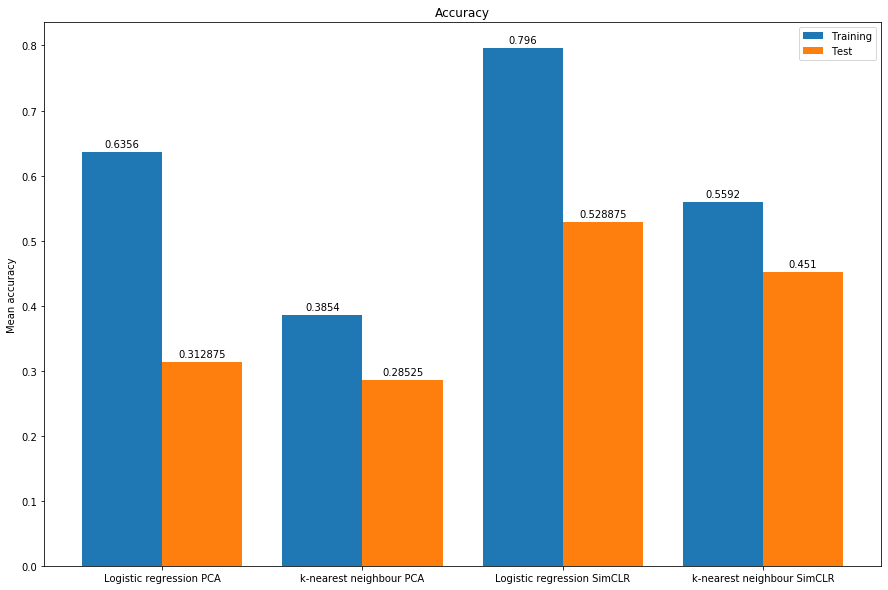

In [16]:
labels = ['Logistic regression PCA', 'k-nearest neighbour PCA', 'Logistic regression SimCLR', 'k-nearest neighbour SimCLR']
train = [reg_train_score_pca, knn_train_score_pca, reg_train_score_mod, knn_train_score_mod]
test = [reg_test_score_pca, knn_test_score_pca, reg_test_score_mod, knn_test_score_mod]

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train, width, label='Training')
rects2 = ax.bar(x + width/2, test, width, label='Test')

ax.set_ylabel('Mean accuracy')
ax.set_title('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()
